In [2]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [3]:
path = '/content/Gia SMP va SMPcap 2021(Giá thị trường SMP) (1).csv'
df = pd.read_csv(path, sep=';', encoding = 'ISO-8859-1')
df


,Date,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.1,1002.0,1002.0
361,28/12/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,...,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0
362,29/12/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5
363,30/12/2021,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,...,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6,1022.6


In [4]:
feats= ['9']

In [5]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler()
X=transformer.fit_transform(np.array(df[feats]).reshape(-1,1))


In [6]:
BGM = BayesianGaussianMixture(n_components=7,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [7]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats)
df_new[[f'predict_proba_{i}' for i in range(7)]]=pp
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)

train_index=np.array([])
for n in range(7):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [8]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7}

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)

    model = lgb.train(params = params_lgb,
                train_set = tr_dataset,
                valid_sets =  vl_dataset,
                num_boost_round = 5000,
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])

    model_list.append(model)

[200]	valid_0's multi_logloss: 0.000151038
[400]	valid_0's multi_logloss: 0.000151038
[200]	valid_0's multi_logloss: 0.000151576
[400]	valid_0's multi_logloss: 0.000151576
[200]	valid_0's multi_logloss: 0.00015433
[400]	valid_0's multi_logloss: 0.00015433
[200]	valid_0's multi_logloss: 0.000155486
[400]	valid_0's multi_logloss: 0.000155486
[200]	valid_0's multi_logloss: 0.000153559
[400]	valid_0's multi_logloss: 0.000153559
[200]	valid_0's multi_logloss: 0.000155711
[400]	valid_0's multi_logloss: 0.000155711
[200]	valid_0's multi_logloss: 8.58365e-06
[400]	valid_0's multi_logloss: 8.48634e-06
[600]	valid_0's multi_logloss: 8.42158e-06
[800]	valid_0's multi_logloss: 8.37546e-06
[1000]	valid_0's multi_logloss: 8.34101e-06
[1200]	valid_0's multi_logloss: 8.3143e-06
[1400]	valid_0's multi_logloss: 8.29302e-06
[1600]	valid_0's multi_logloss: 8.27566e-06
[1800]	valid_0's multi_logloss: 8.26123e-06
[2000]	valid_0's multi_logloss: 8.24906e-06
[2200]	valid_0's multi_logloss: 8.23866e-06
[2400]	

In [9]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [10]:
labels=np.argmax(lgb_preds,axis=1)

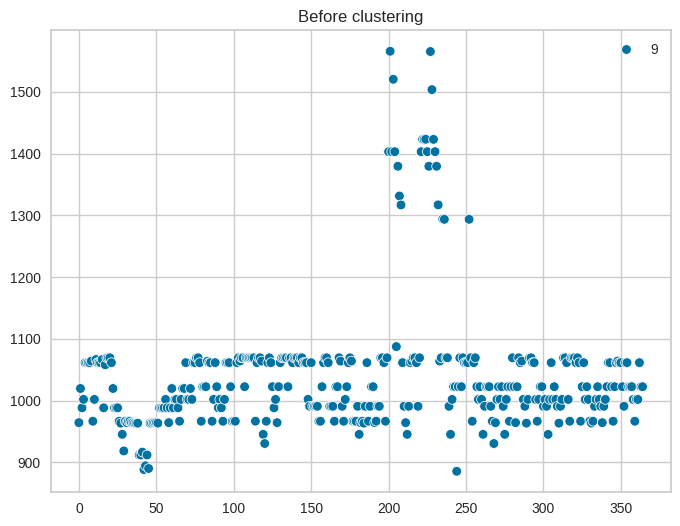

In [11]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(label="bla")
sns.scatterplot(df[feats], marker='o');
ax.set_title("Before clustering");

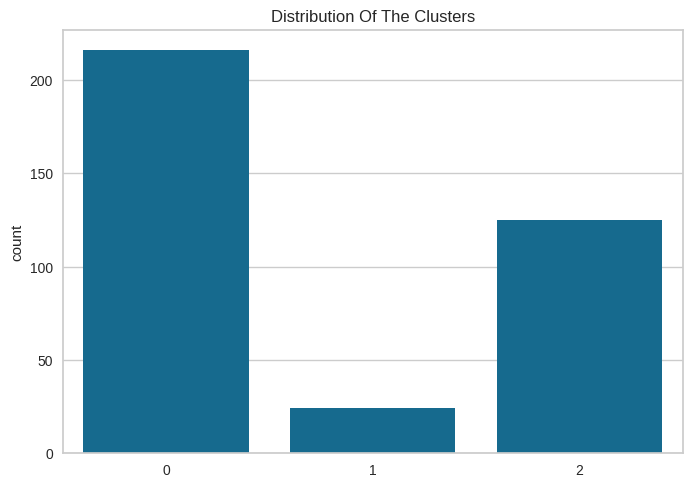

In [12]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

In [13]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [14]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [15]:
test_size = df[df['Date'].dt.month==12].shape[0]
test_size

31

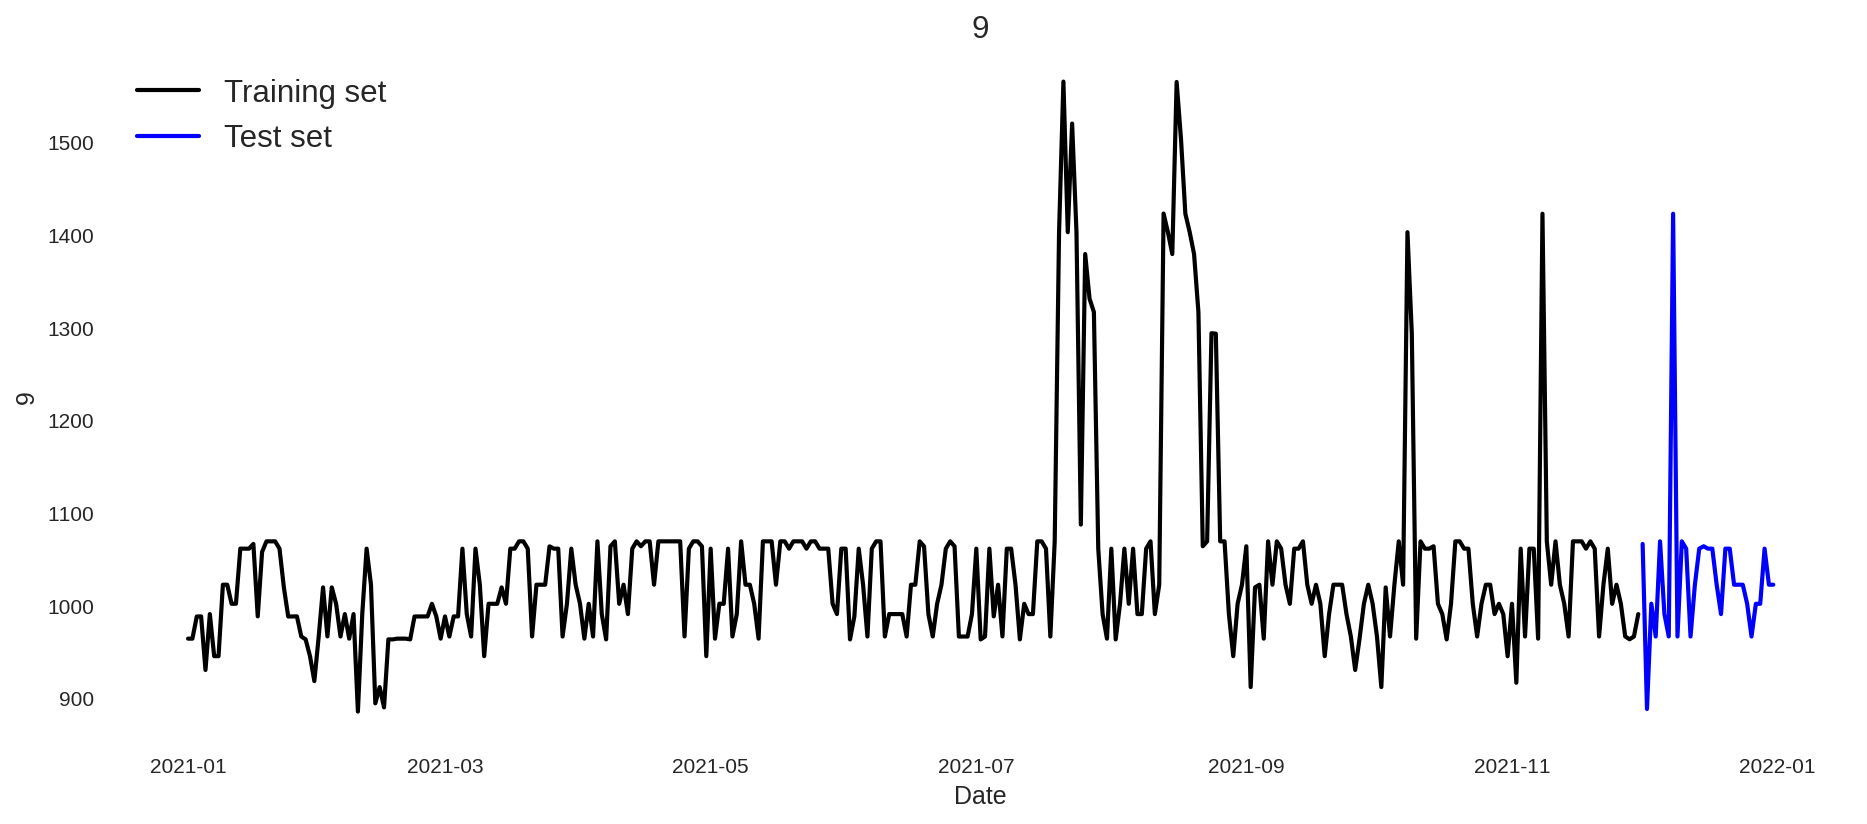

In [16]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'][:-test_size], df['9'][:-test_size], color='black', lw=2)
plt.plot(df['Date'][-test_size:], df['9'][-test_size:], color='blue', lw=2)
plt.title('9', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('9', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [17]:
import plotly.express as px
fig = px.line(y=df['9'], x=df['Date'])
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="4",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,255,255,0.8)')

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df['9'].values.reshape(-1,1))

MinMaxScaler()

In [19]:
window_size = 5

In [20]:
train_data = df['9'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [21]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [22]:
test_data = df['9'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [23]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [24]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [25]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [26]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()

    return model

In [27]:
model = define_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
18/18 [==============================] - 4s 42ms/step - loss: 0.1106 - val_loss: 0.0636
Epoch 2/100
18/18 [==============================] - 0s 1

In [28]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 [==============================] - 1s 691ms/step


In [29]:
from sklearn.metrics import mean_absolute_percentage_error,accuracy_score,r2_score
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1-MAPE

In [30]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.021253392100334167
Test MAPE: 1.8608889650183271
Test Accuracy: -0.8608889650183271


In [31]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

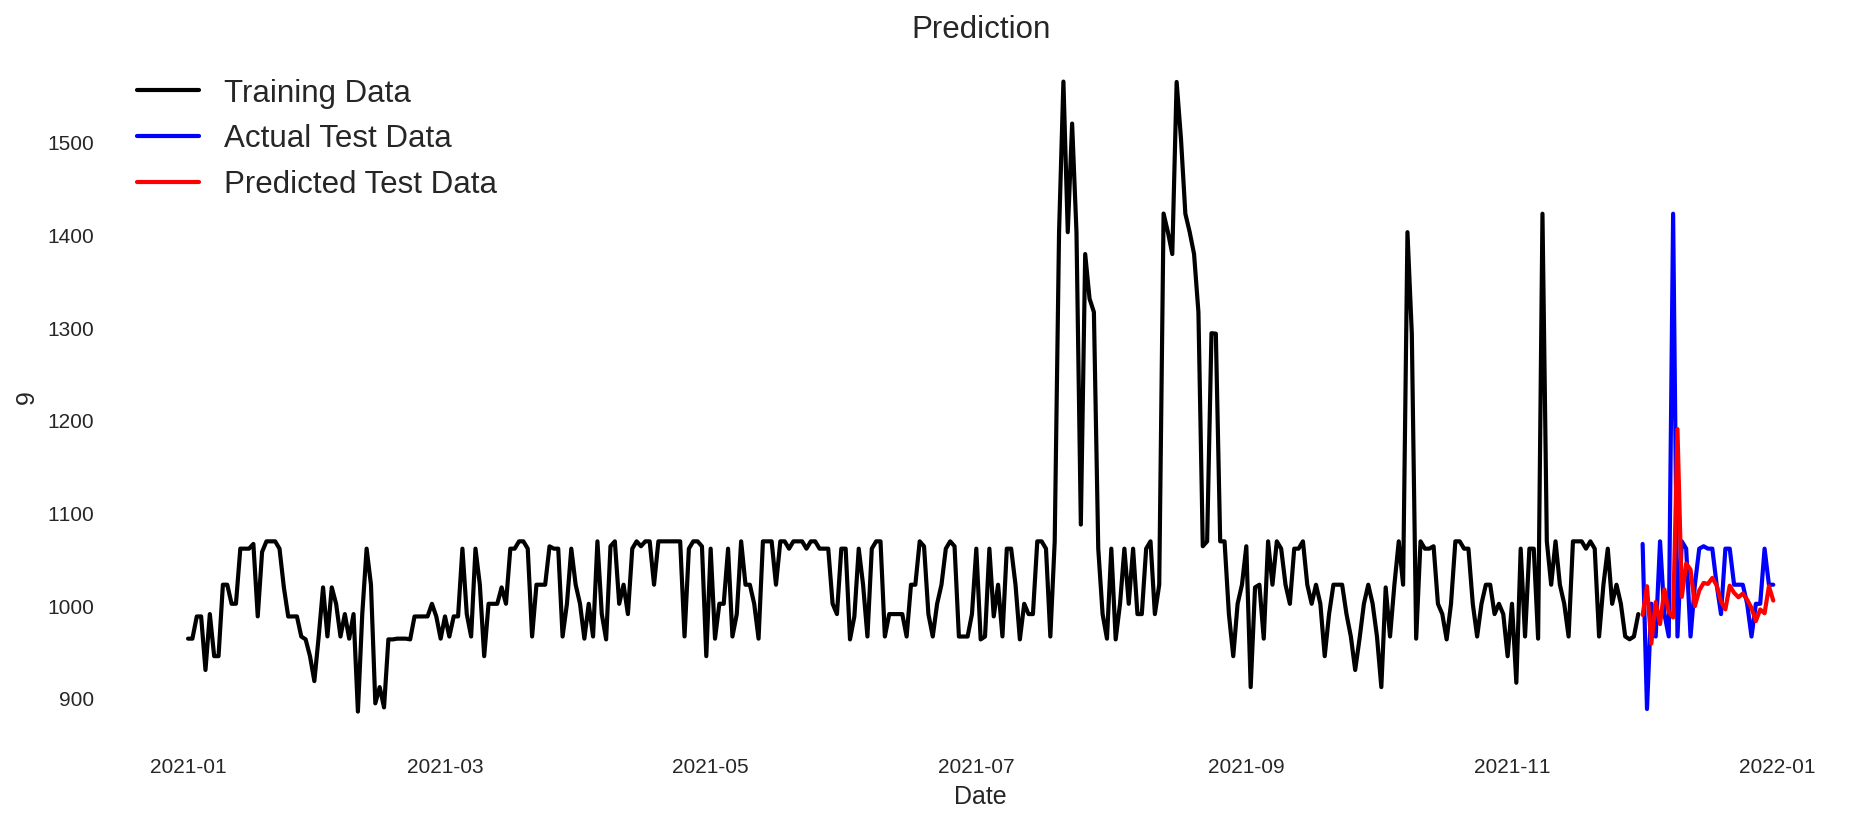

In [32]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('9', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [34]:
train_size = int(len(df[feats])*0.9)
data_train_arm, data_test_arm = df[feats][:train_size], df[feats][train_size:]

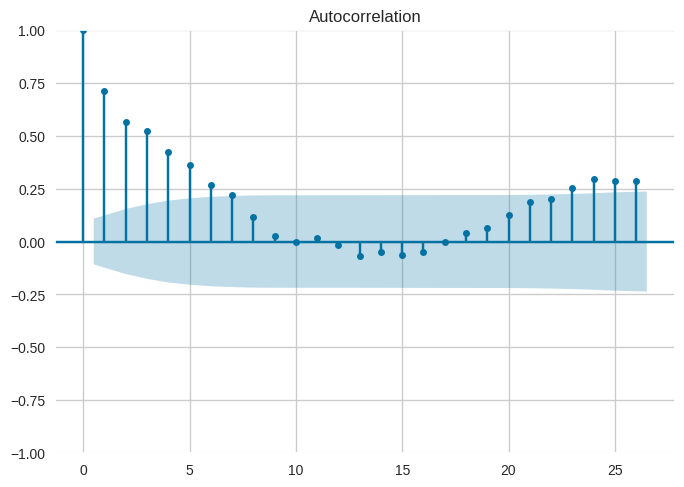

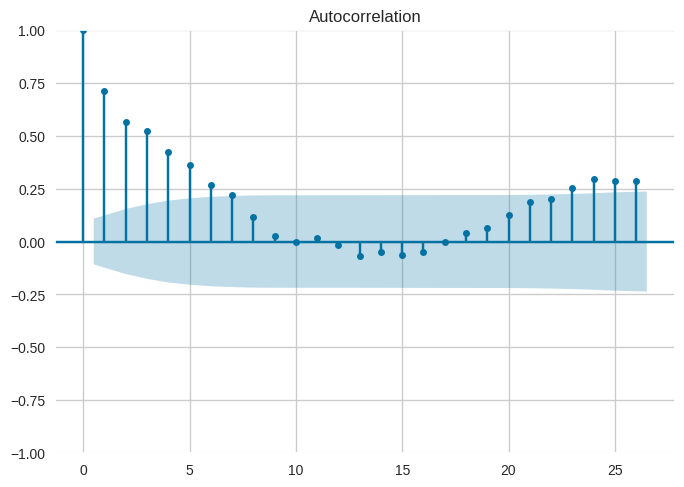

In [35]:
acf_orinal = plot_acf(data_train_arm)
pacf_orinal = plot_acf(data_train_arm)


In [36]:
adf_test = adfuller(df[feats])
print('p-value: %f' % adf_test[1])

p-value: 0.000108


In [37]:
p,d,q = 0,1,0
P,D,Q,s = 1,1,1,10

In [45]:
model_sarima = SARIMAX(data_train_arm, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()

In [39]:
forecast_diff = model_fit_sarima.forecast(steps=len(data_test_arm))
forecast = forecast_diff.values
print(forecast)

[ 998.57023713  972.56927122  999.11922471 1016.64226265  989.74041995
  984.48020248 1006.05601519  995.07066995 1002.13605774 1000.08685734
 1006.52822673  982.9456114  1007.02615297 1022.18459342  998.5196711
  993.01392738 1003.76562244  999.00128506 1009.02761105 1001.63491014
 1007.15816524  983.35061905 1007.66084069 1023.03921243  999.07322405
  993.59031673 1005.34876328 1000.00580979 1009.75673882 1002.86103705
 1008.46968599  984.68306062 1008.97191971 1024.32983563 1000.39184942
  994.90681808 1006.57162665]


In [40]:
df_pre_goc = forecast_diff.cumsum() + data_train_arm.iloc[-1]
df_pre_goc

328   NaN
329   NaN
330   NaN
331   NaN
332   NaN
333   NaN
334   NaN
335   NaN
336   NaN
337   NaN
338   NaN
339   NaN
340   NaN
341   NaN
342   NaN
343   NaN
344   NaN
345   NaN
346   NaN
347   NaN
348   NaN
349   NaN
350   NaN
351   NaN
352   NaN
353   NaN
354   NaN
355   NaN
356   NaN
357   NaN
358   NaN
359   NaN
360   NaN
361   NaN
362   NaN
363   NaN
364   NaN
9     NaN
dtype: float64

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7879 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND DOT BELOW}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7893 (\N{LATIN SMALL LETTER O WITH CIRCUMFLEX AND HOOK ABOVE}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7871 (\N{LATIN SMALL LETTER E WITH CIRCUMFLEX AND ACUTE}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7921 (\N{LATIN SMALL LETTER U WITH HORN AND DOT BELOW}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7917 (\N{LATIN SMALL LETTER U WITH HORN AND HOOK ABOVE}) missing from current font.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 7909 (\N{LAT

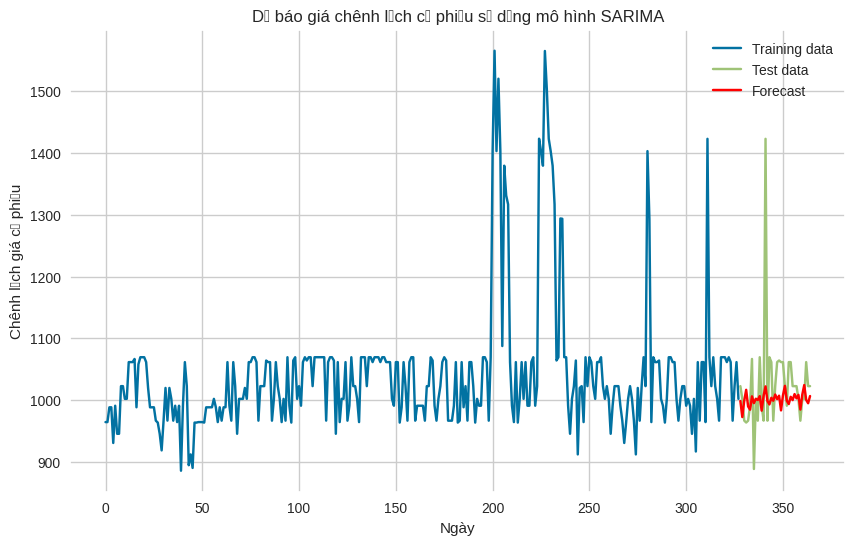

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(data_train_arm.index, data_train_arm, label='Training data')
plt.plot(data_test_arm.index, data_test_arm, label='Test data')
plt.plot(data_test_arm.index, forecast_diff, color='red', label='Forecast')
plt.title('Dự báo giá chênh lệch cổ phiếu sử dụng mô hình SARIMA')
plt.xlabel('Ngày')
plt.ylabel('Chênh lệch giá cổ phiếu')
plt.legend()
plt.show()

